## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Загружаем библиотеку Pandas и считываем данные в датафрейм

In [1]:
import pandas as pd
data_raw=pd.read_csv('/datasets/data.csv')

Получаем общую информацию о данных, просматриваем случайные 10 строк таблицы

In [2]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
data_raw.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14180,1,-1884.502643,32,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,175541.898827,покупка жилья для сдачи
19498,0,NaN,58,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,покупка жилья
15180,2,-1521.176538,46,среднее,1,в разводе,3,F,сотрудник,0,211884.660549,операции со своей недвижимостью
3440,2,-4951.136006,40,неоконченное высшее,2,женат / замужем,0,M,сотрудник,0,224330.912170,операции с жильем
12111,0,NaN,40,высшее,0,женат / замужем,0,M,компаньон,0,NaN,строительство недвижимости
12740,2,-2411.583065,39,среднее,1,гражданский брак,1,F,сотрудник,0,111232.435368,свадьба
19178,1,-120.139684,39,высшее,0,гражданский брак,1,F,компаньон,0,96370.444597,на проведение свадьбы
10024,3,-1916.533407,35,ВЫСШЕЕ,0,женат / замужем,0,F,госслужащий,0,147113.686274,заняться высшим образованием
14365,0,332347.843594,58,среднее,1,женат / замужем,0,F,пенсионер,0,43322.858344,получение образования
18813,0,-1798.667806,26,среднее,1,женат / замужем,0,F,компаньон,0,112676.089877,операции с недвижимостью


Сводная статистика для численных переменных: 

In [4]:
data_raw.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Определим % пропусков в столбце ежемесячного дохода (total_income):

In [5]:
print(f"процент пропущенных значений: {((data_raw['total_income'].isnull().sum())/len(data_raw))*100:.2f}%")

процент пропущенных значений: 10.10%


Посмотрим соотношение представленных данных по целевому показателю-debt (погашение кредита в срок)

In [6]:
credit_unpaid=data_raw[data_raw['debt']==1].shape[0]
credit_paid=data_raw[data_raw['debt']==0].shape[0]
print("кредит просрочен", credit_unpaid)
print("кредит выплачен", credit_paid)
print(f"просрочен/выплачен {credit_unpaid / credit_paid * 100:.2f}%")   

кредит просрочен 1741
кредит выплачен 19784
просрочен/выплачен 8.80%


Посмотрим как представлены текстовые переменные. Выводим уникальные значения.

In [7]:
data_raw['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [8]:
data_raw['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [9]:
data_raw['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [10]:
data_raw['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [11]:
data_raw['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [12]:
data_raw['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

### Вывод

Выборка по данным заемщиков содержит столбцы с текстовыми (object),целочисленными значениями (int64), а так же  числами с плавающей запятой (float64).

Данные содержат пропуски в количестве 10%( days_employed, total_income), дубликаты (education, family_status), аномальные значения (days_employed, children, gender).

Набор данных несбалансирован - записи с невыплаченным кредитом составляют лишь 8,8% от общего количества.
Это повышает вероятность так называемой "ошибки выжившего".По «выжившим» (вернувшим кредит) у нас имеется информация, а по «погибшим» (должникам)- отсутствует или ее мало. На этом основании могут быть сделаны неверные выводы.

Для ответа на вопросы исследования нам достаточно ограничится данными о количестве детей,семейном положении, факте возврата кредита, месячного дохода и цели займа. 

### Шаг 2. Предобработка данных

### Обработка пропусков

Данные колонки total_income содержат 10% пропусков. Посмотрим на распределение данных

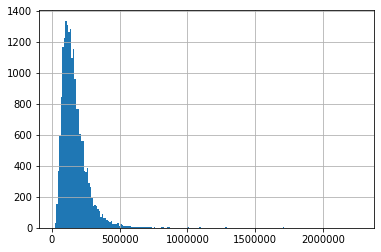

In [13]:
data_raw['total_income'].hist(bins=200)

Заменим пропущенные значения на среднее и посмотрим что получится

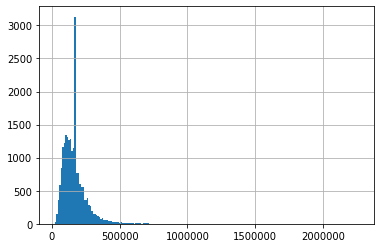

In [14]:
data_median=data_raw['total_income'].fillna(data_raw['total_income'].mean()).hist(bins=200)

Замена пропусков на среднее значение/медиану по всей выборке существенно искажает картину распределения величины месячного дохода.
Удалим строки с отсутствующими значениями и посмотрим как это повлияет на соотношение плохой/хороший заемщик в нашей выборке.

In [15]:
data=data_raw.dropna(axis = "rows")
credit_unpaid=data[data['debt']==1].shape[0]
credit_paid=data[data['debt']==0].shape[0]
print("кредит просрочен", credit_unpaid)
print("кредит выплачен", credit_paid)
print(f"просрочен/выплачен {credit_unpaid / credit_paid* 100 :.2f}%") 
print("размерность нового массива", data.shape)

кредит просрочен 1571
кредит выплачен 17780
просрочен/выплачен 8.84%
размерность нового массива (19351, 12)


### Вывод

Пропуски в колонке были удалены. Более изощренный вариант обработки, например замена на среднее значение по социальным группам, представленным в колонке income_type, более похожа на конструирование параллельной реальности. Соотношение числа "плохих" и "хороших" клиентов в выборке практически не изменилось. Целесообразно продолжить работу с новым набором данных, помещенных в датафрейм -data.

###  Обработка аномальных значений

Как мы уже ранее выяснили, данные о наличии детей содержат отрицательные и аномально большие величины.
посмотрим сколько их:

In [16]:
data["children"].value_counts()


 0     12710
 1      4343
 2      1851
 3       294
 20       67
-1        44
 4        34
 5         8
Name: children, dtype: int64

Если считать количество детей от 0 до 5 нормой, то 67 заемщиков с 20 детьми это уже артефакт! 20 похоже на ошибку оператора-при вводе с помощью  цифрового блока клавиатуры  могли быть нажаты одновременно 2 цифры. -1 -природа ошибки непонятна.
Определим общее число таких артефактов:

In [17]:
data[(data['children']).isin([-1,20])].shape[0]

111

Произведем замену - значения 20 на 2, а -1 на 0 и проверим получившийся результат

In [18]:
data.loc[data['children']<0,'children']=0
data.loc[data['children']==20,'children']=2
data["children"].value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0    12754
1     4343
2     1918
3      294
4       34
5        8
Name: children, dtype: int64

Аномальное значение XNA в колонке gender.

Попробуем по дополнительным данным уточнить пол этого заемщика.

In [19]:
data.loc[data['gender']=='XNA']


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Данные о семейном положении -"гражданский брак" не позволяют уточнить пол заемщика. 

### Вывод

Проанализированы и обработаны аномальные данные по заемщикам. Данныые по количеству детей исправлены в соответствии с природой ошибки ввода. Строка с аномальным значением пола оставлена, поскольку в целях исследования не фигурирует связь пола заемщика со способностью расплатиться с кредитом.

### Замена типа данных

Столбец с данными о днях трудового стажа содержит дробные данные и отрицательные значения.
Испарвить это можно применив методы смена типа данных колонки и замены текущих значений на абсолютные:

In [20]:
data['days_employed'] = data['days_employed'].astype('int').abs()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
data['days_employed'].dtype

dtype('int64')

### Вывод

Был изменен тип данных у столбца days_employed. Возможная причина ошибочного определения данных, как float64 -ошибка при импорте.

### Обработка дубликатов

Данные по образованию клиентов содержат дубликаты - значения отличаются регистром ввода.
Определим количество таких дубликатов:

In [22]:
data['education'].value_counts()

среднее                12342
высшее                  4222
СРЕДНЕЕ                  705
Среднее                  646
неоконченное высшее      613
ВЫСШЕЕ                   251
Высшее                   243
начальное                231
Неоконченное высшее       40
НЕОКОНЧЕННОЕ ВЫСШЕЕ       22
НАЧАЛЬНОЕ                 16
Начальное                 14
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Кроме того в колонке family_status есть записи с предлогом "Не" в верхнем регистре.
Целесообразно унифицировать данные(перевести все записи в нижний регистр) сразу во всем датафрейме и таким образом избавиться от дубликатов:


In [23]:
data = data.applymap(lambda x: x.lower() if type(x) == str else x)   
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

### Вывод

Текстовые данные во всех колонках приведены к нижнему регистру. Таким образом мы избавились от дубликатов в колонке education.


### Лемматизация

Колонка purpose содержит цели займа, описанные в произвольной форме. Для формализации целей и последующей категоризации можно попробовать привести слова к их словарным формам и определить частоту использования. Это должно облегчить последующий анализ.

In [24]:
from pymystem3 import Mystem
m = Mystem()
cr_cat=data['purpose'].unique()
lemmas_list=[]
for target in cr_cat:
    lemmas=''.join(m.lemmatize(target)).strip()
    lemmas=lemmas.split()
    lemmas_list+=lemmas
pd.Series(lemmas_list).value_counts()

покупка           10
недвижимость      10
автомобиль         9
образование        9
жилье              7
с                  5
свой               4
операция           4
на                 4
строительство      3
свадьба            3
получение          3
высокий            3
заниматься         2
дополнительный     2
для                2
жилой              2
сделка             2
коммерческий       2
подержать          1
со                 1
собственный        1
семья              1
сдача              1
приобретение       1
проведение         1
сыграть            1
профильный         1
ремонт             1
подержанный        1
dtype: int64

создадим словарь категорий целей займа

In [25]:
credit_target=['жилье','автомобиль','образование','недвижимость','свадьба','строительство','ремонт']

Создадим функцию для анализа целей кредита для каждого заемщика. Текст из ячейки лемматизируется и сравнивается со нашим словарем. При наличии совпадения берется соответствующее значение из словаря для дальнейшего использования.

In [26]:
from pymystem3 import Mystem
m = Mystem()
def credit_purpose(purpose):
    lemmas=m.lemmatize(purpose)
    for lemma in lemmas:
        if lemma in credit_target:
            return lemma


Создадим новую колонку с категоризированными целями кредита и применив методом apply нашу функцию:

In [27]:
data['purpose_c']=data['purpose'].apply(credit_purpose)  

посмотрим на данные:

In [28]:
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_c
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628.550329,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,m,компаньон,0,255763.565419,покупка жилья,жилье
6,0,2879,43,высшее,0,женат / замужем,0,f,компаньон,0,240525.971920,операции с жильем,жилье
7,0,152,50,среднее,1,женат / замужем,0,m,сотрудник,0,135823.934197,образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,f,сотрудник,0,95856.832424,на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,m,сотрудник,0,144425.938277,покупка жилья для семьи,жилье


### Вывод

Категоризация целей кредита произведена с помощью т.н. приведение слов к их словарным формам. Для формирования словаря категорий так же была применена лемматизация(код взят из треда в Slack нашей когорты). В результате, кроме очевидных -свадьба, автомобиль,итд.,были добавлены категории "ремонт" и "строительство".

### Категоризация данных

Для ответа на вопрос о влиянии семейного положения на возврат кредита в срок целесообразно переопределить переменную 'family_status', заменив юридичесий смысл на экономический. С экономической точки зрения 'family_status' должена отвечать на вопрос-"участвует ли клиент в ведении совместного хозяйства?", так как именно это влияет на кредитоспособность. Поэтому можно свести количество категорий 'family_status' к 2- "в браке","одинок(а)

In [29]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [30]:
data.loc[data['family_status']== 'женат / замужем', 'family_status']='в браке'
data.loc[data['family_status']== 'гражданский брак', 'family_status']='в браке'
data.loc[data['family_status']!= 'в браке', 'family_status']='одинок(а)'
data.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_c
3487,0,361290,52,среднее,1,в браке,0,f,пенсионер,0,172403.629848,автомобили,автомобиль
11949,3,1604,51,высшее,0,в браке,0,m,компаньон,0,221588.103812,свой автомобиль,автомобиль
11933,2,698,28,среднее,1,в браке,0,m,компаньон,0,160199.330386,заняться высшим образованием,образование
394,0,2777,30,среднее,1,в браке,0,m,сотрудник,0,121759.963012,покупка коммерческой недвижимости,недвижимость
18580,2,1954,34,среднее,1,в браке,0,f,компаньон,0,274044.383463,операции с жильем,жилье
6021,0,350896,67,среднее,1,одинок(а),2,f,пенсионер,0,96021.494193,покупка жилья для семьи,жилье
4861,0,362572,58,среднее,1,в браке,1,f,пенсионер,0,109366.389226,сыграть свадьбу,свадьба
20507,0,307,29,неоконченное высшее,2,одинок(а),4,m,компаньон,0,238957.547086,сделка с подержанным автомобилем,автомобиль
4607,1,958,58,среднее,1,в браке,0,f,сотрудник,0,117748.582032,заняться образованием,образование
6912,0,339929,58,среднее,1,в браке,0,f,пенсионер,0,132602.557332,получение дополнительного образования,образование


Для ответа на вопрос о связи дохода заемщиков с вероятностью погашения кредита целесообразно категоризировать размер дохода.
Введем категории 'ниже среднего'-с доходом ниже чем среднее значение по выборке и'выше среднего'.
Для категоризации используем функцию, которую применим ко всем данным колонки 'total_income'. категории запишем в новую колонку

In [31]:
def income_rate(income):
        income_mean=data['total_income'].mean()
        if income <= income_mean:
            return 'ниже среднего'
        return 'выше среднего'


In [32]:
data['income_status']=data['total_income'].apply(income_rate)
data.sample()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_c,income_status
5685,0,1134,61,среднее,1,в браке,0,m,сотрудник,0,165863.523445,на покупку автомобиля,автомобиль,ниже среднего


### Вывод

Заемщики категоризированны в зависимости от размеров дохода и семейного положения

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для ответа на этот вопрос надо оценить отношение  числа плохих и хороших заемщиков  имеющих детей и бездетных.

In [33]:
child_free_debtors=data.loc[(data['children'] == 0) & (data['debt'] > 0)].shape[0]
child_free=data.loc[(data['children'] == 0)].shape[0]
child_free_payers=data.loc[(data['children'] == 0) & (data['debt'] == 0)].shape[0]
with_childs=len(data)-child_free
with_childs_debtors=data.loc[(data['children'] > 0) & (data['debt'] > 0)].shape[0]
print(f"доля бездетных неплательщиков {child_free_debtors/ child_free* 100 :.2f}%") 
print(f"доля неплательщиков, имеющих детей {with_childs_debtors/with_childs* 100 :.2f}%") 


доля бездетных неплательщиков 7.47%
доля неплательщиков, имеющих детей 9.37%


### Вывод

Наличие детей у заемщика увеличивает риск невозврата кредита


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [34]:
married_payers=data.loc[(data['family_status']=='в браке')&(data['debt']==0)].shape[0]
married_debtors=data.loc[(data['family_status']=='в браке')&(data['debt']==1)].shape[0]
single_debtors=data.loc[(data['family_status']=='одинок(а)')&(data['debt']==1)].shape[0]
single_payers=data.loc[(data['family_status']=='одинок(а)')&(data['debt']==0)].shape[0]
print(f"доля семейных неплательщиков {married_debtors/married_payers* 100 :.2f}%") 
print(f"доля одиноких неплательщиков {single_debtors/single_payers* 100 :.2f}%") 

доля семейных неплательщиков 8.65%
доля одиноких неплательщиков 9.44%


### Вывод

Одинокие заемщики чаще не возвращают кредиты.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [35]:
pour_payers=data.loc[(data['income_status']=='ниже среднего')&(data['debt']==0)].shape[0]
pour_debtors=data.loc[(data['income_status']=='ниже среднего')&(data['debt']==1)].shape[0]
rich_debtors=data.loc[(data['income_status']=='выше среднего')&(data['debt']==1)].shape[0]
rich_payers=data.loc[(data['income_status']=='выше среднего')&(data['debt']==0)].shape[0]
print(f"доля бедных неплательщиков {pour_debtors/pour_payers* 100 :.2f}%") 
print(f"доля богатых неплательщиков {rich_debtors/rich_payers* 100 :.2f}%") 

доля бедных неплательщиков 9.21%
доля богатых неплательщиков 8.24%


### Вывод

Люди с высоким уровнем дохода реже становятся должниками.

- Как разные цели кредита влияют на его возврат в срок?

Определим для каждой цели кредита процент задолженности. Поскольку колонка 'debt' содержит 0 для добросовестных клиентов  и 1 для должников, то метод sum() даст нам число должников, а count() общее число займов по каждой категории.

In [36]:
(data.groupby('purpose_c')['debt'].sum()/ data.groupby('purpose_c')['debt'].count())*100



purpose_c
автомобиль       9.417501
жилье            7.185800
недвижимость     7.458976
образование      9.202113
ремонт           5.719557
свадьба          7.527394
строительство    7.818930
Name: debt, dtype: float64

### Вывод

### Шаг 4. Общий вывод

Проанализированы данные о платежеспособности клиентов банка. Данные очищены от дубликатов, аномальных значений, обработаны пропуски, исправлены типы. Для изучения зависимости выплаты займа от различных факторов были введены новые категории на основе либо обобщения имеющихся данных (семейное положение) либо лемматизации с последующим обобщением(цель кредита). В ходе исследованя получены ответы на все вопросы Заказчика. На основе полученных данных можно построить портрет идеального заемщика-богат, состоит в браке, бездетен, берет кредит на ремонт.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x ]  файл изучен;
- [ x]  определены пропущенные значения;
- [x ]  заполнены пропущенные значения;
- [x ]  есть пояснение какие пропущенные значения обнаружены;
- [ x]  описаны возможные причины появления пропусков в данных;
- [x ]  объяснено по какому принципу заполнены пропуски;
- [x ]  заменен вещественный тип данных на целочисленный;
- [ x]  есть пояснение какой метод используется для изменения типа данных и почему;
- [x ]  удалены дубликаты;
- [x ]  есть пояснение какой метод используется для поиска и удаления дубликатов;
- [x ]  описаны возможные причины появления дубликатов в данных;
- [x ]  выделены леммы в значениях столбца с целями получения кредита;
- [x ]  описан процесс лемматизации;
- [x ]  данные категоризированы;
- [ x]  есть объяснение принципа категоризации данных;
- [x ]  есть ответ на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x ]  есть ответ на вопрос "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x ]  есть ответ на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x ]  есть ответ на вопрос "Как разные цели кредита влияют на его возврат в срок?";
- [x ]  в каждом этапе есть выводы;
- [x ]  есть общий вывод.